In [1]:
import QuantLib as ql
from collections import namedtuple
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('seaborn')

## 環境設定

In [2]:
today = ql.Date(15, ql.February, 2021);
settlement= ql.Date(19, ql.February, 2021);
ql.Settings.instance().evaluationDate = today;
term_structure = ql.YieldTermStructureHandle(
    ql.FlatForward(settlement,0.04875825,ql.Actual365Fixed())
    )
index = ql.Euribor1Y(term_structure)

In [3]:
CalibrationData = namedtuple("CalibrationData", 
                             "start, length, volatility") # 不同maturity 的volatility
data = [CalibrationData(1, 5, 0.1148),
        CalibrationData(2, 4, 0.1108),
        CalibrationData(3, 3, 0.1070),
        CalibrationData(4, 2, 0.1021),
        CalibrationData(5, 1, 0.1000 )]

# 透過swaption 的market data 做calibration

In [4]:
def create_swaption_helpers(data, index, term_structure, engine):
    
    swaptions = []
    fixed_leg_tenor = ql.Period(1, ql.Years)
    fixed_leg_daycounter = ql.Actual360()
    floating_leg_daycounter = ql.Actual360()
    
    for d in data:
        vol_handle = ql.QuoteHandle(ql.SimpleQuote(d.volatility))
        helper = ql.SwaptionHelper(ql.Period(d.start, ql.Years),
                                   ql.Period(d.length, ql.Years),
                                   vol_handle,
                                   index,
                                   fixed_leg_tenor,
                                   fixed_leg_daycounter,
                                   floating_leg_daycounter,
                                   term_structure
                                   )
        helper.setPricingEngine(engine)
        swaptions.append(helper)
    return swaptions    

In [5]:
def calibration_report(swaptions, data):
    
    print("-"*82)
    print("%15s %15s %15s %15s %15s" % \
    ("Model Price", "Market Price", "Implied Vol", "Market Vol", "Rel Error"))
    print("-"*82)
    
    
    cum_err = 0.0
    for i, s in enumerate(swaptions):
        model_price = s.modelValue()
        market_vol = data[i].volatility
        black_price = s.blackPrice(market_vol)
        rel_error = model_price/black_price - 1.0
        implied_vol = s.impliedVolatility(model_price,
                                          1e-5, 50, 0.0, 0.50)
        rel_error2 = implied_vol/market_vol-1.0
        cum_err += rel_error2*rel_error2
        
        print("%15.5f %15.5f %15.5f %15.5f %15.5f" % \
        (model_price, black_price, implied_vol, market_vol, rel_error))
    print("-"*82)
    print("Cumulative Error : %15.5f" % math.sqrt(cum_err))

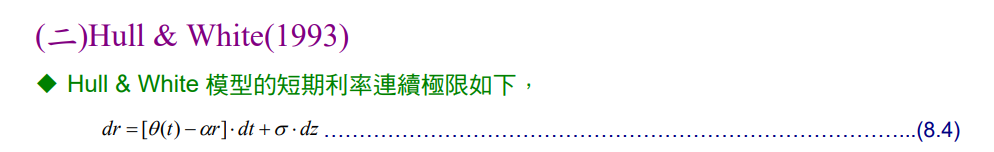

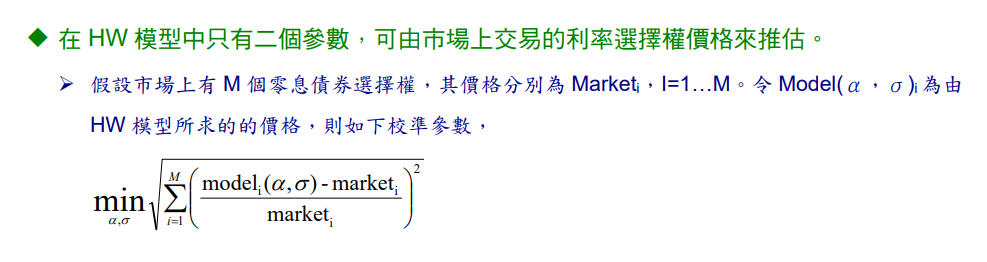

In [6]:
model = ql.HullWhite(term_structure);
engine = ql.JamshidianSwaptionEngine(model)
swaptions = create_swaption_helpers(data, index, term_structure, engine)

optimization_method = ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8)
end_criteria = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
model.calibrate(swaptions, optimization_method, end_criteria)

a, sigma = model.params()
print("alpha = %6.5f, sigma = %6.5f" % (a, sigma))
calibration_report(swaptions, data)

alpha = 0.04915, sigma = 0.00584
----------------------------------------------------------------------------------
    Model Price    Market Price     Implied Vol      Market Vol       Rel Error
----------------------------------------------------------------------------------
        0.00880         0.00951         0.10620         0.11480        -0.07488
        0.00967         0.01007         0.10632         0.11080        -0.04039
        0.00866         0.00871         0.10635         0.10700        -0.00606
        0.00650         0.00623         0.10644         0.10210         0.04234
        0.00354         0.00332         0.10659         0.10000         0.06561
----------------------------------------------------------------------------------
Cumulative Error :         0.11594


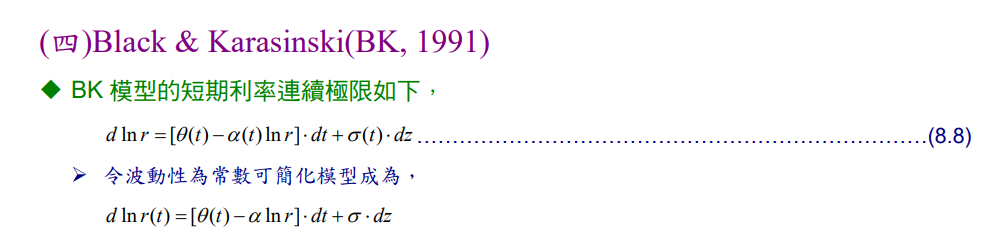

In [7]:
model = ql.BlackKarasinski(term_structure);
engine = ql.TreeSwaptionEngine(model, 100)
swaptions = create_swaption_helpers(data, index, term_structure, engine)

optimization_method = ql.LevenbergMarquardt(1.0e-8,1.0e-8,1.0e-8)
end_criteria = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
model.calibrate(swaptions, optimization_method, end_criteria)

a, sigma =  model.params()
print("alpha = %6.5f, sigma = %6.5f" % (a, sigma))

alpha = 0.04162, sigma = 0.11782


In [8]:
calibration_report(swaptions, data)

----------------------------------------------------------------------------------
    Model Price    Market Price     Implied Vol      Market Vol       Rel Error
----------------------------------------------------------------------------------
        0.00874         0.00951         0.10550         0.11480        -0.08097
        0.00967         0.01007         0.10633         0.11080        -0.04026
        0.00867         0.00871         0.10655         0.10700        -0.00423
        0.00651         0.00623         0.10665         0.10210         0.04443
        0.00355         0.00332         0.10675         0.10000         0.06714
----------------------------------------------------------------------------------
Cumulative Error :         0.12147


## Pricing Caps and Floors

### 評價caps的步驟
* 1. construct interest rate term structure for discounting
* 2. construct interest rate term structure for the floating leg
* 3. construct the pricing engine to value caps

In [9]:
calc_date = ql.Date(14, 6, 2021)
ql.Settings.instance().evaluationDate = calc_date

In [10]:
dates = [ql.Date(14,6,2021), ql.Date(14,9,2021), 
         ql.Date(14,12,2021), ql.Date(14,6,2022),
         ql.Date(14,6,2024), ql.Date(14,6,2026),
         ql.Date(15,6,2031), ql.Date(16,6,2036),
         ql.Date(16,6,2041), ql.Date(14,6,2051)
         ]
yields = [0.000000, 0.006616, 0.007049, 0.007795,
          0.009599, 0.011203, 0.015068, 0.017583,
          0.018998, 0.020080]
day_count = ql.ActualActual()
calendar = ql.Taiwan()
interpolation = ql.Linear()
compounding = ql.Compounded
compounding_frequency = ql.Annual

term_structure = ql.ZeroCurve(dates, yields, day_count, calendar, 
                       interpolation, compounding, compounding_frequency)

ts_handle = ql.YieldTermStructureHandle(term_structure)

### construct 一個十年期，每三個月比價一次的caps

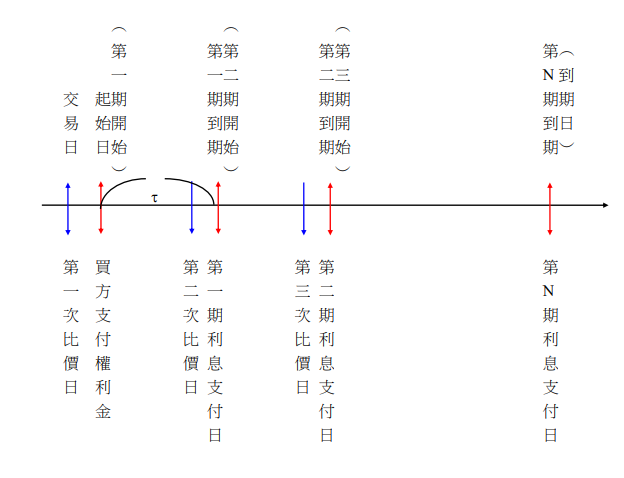

In [11]:
start_date = ql.Date(14, 6, 2021)
end_date = ql.Date(14, 6 , 2031)
period = ql.Period(3, ql.Months)
calendar = ql.Taiwan()
buss_convention = ql.ModifiedFollowing
rule = ql.DateGeneration.Forward
end_of_month = False

schedule = ql.Schedule(start_date, end_date, period,
                       calendar, buss_convention, buss_convention, 
                       rule, end_of_month)

In [12]:
ibor_index = ql.USDLibor(ql.Period(3, ql.Months), ts_handle)
ibor_index.addFixing(ql.Date(10,6,2021), 0.0065560)

ibor_leg = ql.IborLeg([1000000], schedule, ibor_index)

In [13]:
strike = 0.02
cap = ql.Cap(ibor_leg, [strike])

vols = ql.QuoteHandle(ql.SimpleQuote(0.547295))
engine = ql.BlackCapFloorEngine(ts_handle, vols)

cap.setPricingEngine(engine)

In [14]:
cap.NPV()

54408.95638684406

In [15]:
strikes = [0.01,0.015, 0.02]
expiries = [ql.Period(i, ql.Years) for i in range(1,11)] + [ql.Period(12, ql.Years)]
vols = ql.Matrix(len(expiries), len(strikes))
data = [[47.27, 55.47, 64.07, 70.14, 72.13, 69.41, 72.15, 67.28, 66.08, 68.64, 65.83],
   [46.65,54.15,61.47,65.53,66.28,62.83,64.42,60.05,58.71,60.35,55.91],
   [46.6,52.65,59.32,62.05,62.0,58.09,59.03,55.0,53.59,54.74,49.54]
   ]

for i in range(vols.rows()):
    for j in range(vols.columns()):
        vols[i][j] = data[j][i]/100.0

In [16]:
calendar = ql.Taiwan()
bdc = ql.ModifiedFollowing
daycount = ql.Actual365Fixed()
settlement_days = 2
capfloor_vol = ql.CapFloorTermVolSurface(settlement_days, calendar, bdc, expiries, strikes, vols, daycount)

In [17]:
optionlet_surf = ql.OptionletStripper1(capfloor_vol, ibor_index) 
ovs_handle = ql.OptionletVolatilityStructureHandle(
    ql.StrippedOptionletAdapter(optionlet_surf)
)

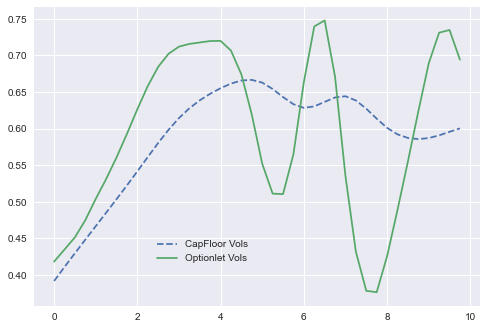

In [18]:
tenors = np.arange(0,10,0.25)
strike = 0.015
capfloor_vols = [capfloor_vol.volatility(t, strike) for t in tenors]
opionlet_vols = [ovs_handle.volatility(t, strike) for t in tenors]

plt.plot(tenors, capfloor_vols, "--", label="CapFloor Vols")
plt.plot(tenors, opionlet_vols,"-", label="Optionlet Vols")
plt.legend(bbox_to_anchor=(0.5, 0.25))

In [19]:
engine2 = ql.BlackCapFloorEngine(ts_handle, ovs_handle)
cap.setPricingEngine(engine2)

In [20]:
cap.NPV()

54427.26567992578